In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')

In [4]:
def generate_points(x_range=(-1, 1), step=0.01):
    """
    Generate a sequence of points within the given range and step.

    Parameters:
    x_range (tuple): Range of x values (min, max).
    step (float): Step size for generating points.

    Returns:
    numpy.ndarray: Array of x values.
    """
    return np.arange(x_range[0], x_range[1], step)

In [5]:
def generate_polynomial_values(x, degree=3, coefficients=None):
    """
    Generate y values based on a polynomial function of a given degree.

    Parameters:
    x (numpy.ndarray): Array of x values.
    degree (int): Degree of the polynomial.
    coefficients (list or None): Coefficients of the polynomial. If None, random coefficients are generated.

    Returns:
    numpy.ndarray: Array of y values.
    """
    if coefficients is None:
        coefficients = np.random.randn(degree + 1)
    print("Coefficients are:", coefficients)
    return np.polyval(coefficients, x), coefficients

In [6]:
def sample_train_set(x, y, train_size=30):
    """
    Sample a training set of a specified size.

    Parameters:
    x (numpy.ndarray): Array of x values.
    y (numpy.ndarray): Array of y values.
    train_size (int): Number of samples for the training set.

    Returns:
    tuple: Arrays of x_train and y_train.
    """
    train_indices = np.random.choice(len(x), train_size, replace=False)
    return x[train_indices], y[train_indices]

In [7]:
def create_bootstraps_with_indices(x_train, y_train, n_bootstraps=3, degree=1):
    """
    Create bootstrap samples and train polynomial models on each.
    Also, return the indices used for each bootstrap sample.

    Parameters:
    x_train (numpy.ndarray): Array of x values in the training set.
    y_train (numpy.ndarray): Array of y values in the training set.
    n_bootstraps (int): Number of bootstrap samples to create.
    degree (int): Degree of the polynomial model to fit.

    Returns:
    list: List of trained polynomial models.
    list: List of indices used for each bootstrap sample.
    """
    models = []
    indices_list = []
    subset_size = len(x_train) // n_bootstraps  # Calculate size of each subset

    for i in range(n_bootstraps):
        # Define start and end indices for the current subset
        start_idx = i * subset_size
        end_idx = (i + 1) * subset_size if i != n_bootstraps - 1 else len(x_train)

        # Create the subset and store indices
        x_subset = x_train[start_idx:end_idx]
        y_subset = y_train[start_idx:end_idx]
        indices_list.append((start_idx, end_idx))

        # Create a polynomial regression model pipeline
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

        # Fit the model to the subset
        model.fit(x_subset.reshape(-1, 1), y_subset)

        # Append the trained model to the list
        models.append(model)

    return models, indices_list


In [8]:
def sample_val_set(x, y, val_size=10):
    """
    Sample a validation set of a specified size.

    Parameters:
    x (numpy.ndarray): Array of x values.
    y (numpy.ndarray): Array of y values.
    val_size (int): Number of samples for the validation set.

    Returns:
    tuple: Arrays of x_val and y_val.
    """
    val_indices = np.random.choice(len(x), val_size, replace=False)
    return x[val_indices], y[val_indices]

In [9]:
# Define the base models (these are the models trained earlier)
class BaseModelEnsemble:
    def __init__(self, models):
        self.models = models

    def predict(self, x):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(x.reshape(-1, 1)).reshape(-1))
        return np.array(predictions).T  # Shape (n_samples, n_models)

In [10]:
class WeightedEnsembleNetwork(nn.Module):
    def __init__(self, input_dim=1, n_models=3, hidden_dim=10):
        super(WeightedEnsembleNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, n_models)
        self.softmax = nn.Softmax(dim=1)  # Ensure outputs sum to 1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        phi = self.softmax(self.fc2(x))
        return phi

def train_weighted_ensemble_network(x_val, f_val, y_val, hidden_dim=10, n_epochs=1000, learning_rate=0.01):
    input_dim = 1  # Single feature (x)
    n_models = f_val.shape[1]  # Number of base models

    ensemble_net = WeightedEnsembleNetwork(input_dim=input_dim, n_models=n_models, hidden_dim=hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ensemble_net.parameters(), lr=learning_rate)

    x_val_tensor = torch.tensor(x_val.reshape(-1, 1), dtype=torch.float32)
    f_val_tensor = torch.tensor(f_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

    for epoch in range(n_epochs):
        # Predict the weights (phis)
        phis = ensemble_net(x_val_tensor)

        # Compute the weighted sum of the base model predictions
        y_pred = torch.sum(phis * f_val_tensor, dim=1).reshape(-1, 1)

        # Compute the loss
        loss = criterion(y_pred, y_val_tensor)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return ensemble_net

def predict_with_weighted_ensemble(ensemble_net, f_test, x_test):
    x_test_tensor = torch.tensor(x_test.reshape(-1, 1), dtype=torch.float32)
    f_test_tensor = torch.tensor(f_test, dtype=torch.float32)

    # Predict the weights (phis) using the trained network
    phis = ensemble_net(x_test_tensor)

    # Compute the final prediction as the weighted sum
    y_test_pred = torch.sum(phis * f_test_tensor, dim=1).detach().numpy()

    return y_test_pred

In [11]:
class DirectEnsembleNetwork(nn.Module):
    def __init__(self, n_models=3, hidden_dim=10, output_dim=1):
        super(DirectEnsembleNetwork, self).__init__()
        self.fc1 = nn.Linear(n_models, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        y_pred = self.fc2(x)
        return y_pred

def train_direct_ensemble_network(f_val, y_val, hidden_dim=10, n_epochs=5000, learning_rate=0.01):
    n_models = f_val.shape[1]  # Number of base models

    ensemble_net = DirectEnsembleNetwork(n_models=n_models, hidden_dim=hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(ensemble_net.parameters(), lr=learning_rate)

    f_val_tensor = torch.tensor(f_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

    for epoch in range(n_epochs):
        # Compute the network's prediction
        y_pred = ensemble_net(f_val_tensor)

        # Compute the loss
        loss = criterion(y_pred, y_val_tensor)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return ensemble_net

def predict_with_direct_ensemble(ensemble_net, f_test):
    f_test_tensor = torch.tensor(f_test, dtype=torch.float32)

    # Compute the final prediction
    y_test_pred = ensemble_net(f_test_tensor).detach().numpy().reshape(-1)

    return y_test_pred

In [12]:

class FixedWeightEnsembleNetwork(nn.Module):
    def __init__(self, n_models=3):
        super(FixedWeightEnsembleNetwork, self).__init__()
        # Initialize weights for each base model's predictions
        self.weights = nn.Parameter(torch.randn(n_models))  # Learnable weights

    def forward(self, f_pred):
        """
        f_pred: Tensor of shape [batch_size, num_models]
            - The predictions from the base models.
        """
        # Apply softmax to ensure weights sum to 1
        w_norm = torch.nn.functional.softmax(self.weights, dim=0)

        # Compute the weighted sum of the base model predictions
        y_pred = torch.sum(w_norm * f_pred, dim=1)

        return y_pred, w_norm

def train_fixed_weight_ensemble(f_val, y_val, n_epochs=1000, learning_rate=0.01):
    n_models = f_val.shape[1]  # Number of base models

    # Initialize the model
    ensemble_net = FixedWeightEnsembleNetwork(n_models=n_models)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(ensemble_net.parameters(), lr=learning_rate)

    # Convert validation data to tensors
    f_val_tensor = torch.tensor(f_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).reshape(-1, 1)

    # Training loop
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred, _ = ensemble_net(f_val_tensor)
        loss = criterion(y_pred, y_val_tensor)
        loss.backward()
        optimizer.step()

    return ensemble_net

def predict_with_fixed_weight_ensemble(ensemble_net, f_test):
    f_test_tensor = torch.tensor(f_test, dtype=torch.float32)

    # Compute the final prediction
    y_test_pred, learned_weights = ensemble_net(f_test_tensor)

    return y_test_pred.detach().numpy(), learned_weights.detach().numpy()

In [13]:
def plot_ensemble_results(x, y_true, base_models, x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels):
    """
    Plot the true polynomial, base models, training data, and ensemble predictions.
    Include markers to indicate which training points correspond to which base model.

    Parameters:
    - x (numpy.ndarray): The x values for the true polynomial and predictions.
    - y_true (numpy.ndarray): The y values of the true polynomial.
    - base_models (list): List of base model predictions.
    - x_train (numpy.ndarray): The x values for the training data.
    - y_train (numpy.ndarray): The y values for the training data.
    - indices_list (list): List of indices indicating which training points correspond to which base model.
    - x_val (numpy.ndarray): The x values for the validation data.
    - y_true_val (numpy.ndarray): True y values of the polynomial at validation points.
    - ensemble_predictions (list of numpy.ndarray): Predictions from the ensemble models.
    - labels (list of str): Labels for each ensemble prediction (e.g., ["y_pred1", "y_pred2", "y_pred3"]).
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # First row: Plot only in the center figure
    # Hide the left and right plots in the first row
    for ax in [axs[0, 0], axs[0, 2]]:
        ax.axis('off')

    # Center plot in the first row (True polynomial, base models, and training data)
    ax_center = axs[0, 1]
    ax_center.plot(x, y_true, label='True Polynomial', color='black', linewidth=2)

    # Plot base models and training data
    colors = ['red', 'green', 'blue']
    markers = ['o', 's', '^']

    for i, (f_model, (start_idx, end_idx)) in enumerate(zip(base_models, indices_list)):
        ax_center.plot(x, f_model, label=f'Base Model {i+1}', color=colors[i], linestyle='--')
        ax_center.scatter(x_train[start_idx:end_idx], y_train[start_idx:end_idx], color=colors[i], label=f'Training Data {i+1}', s=30, marker=markers[i])

    # Plot the validation data (same for all models)
    ax_center.scatter(x_val, y_true_val, color='black', label='Validation Data', s=30, marker='x')

    ax_center.set_title('Base Models and Training Data')
    ax_center.set_xlabel('X')
    ax_center.set_ylabel('Y')
    ax_center.legend()
    ax_center.grid(True)

    colors = ['orange', 'purple', 'brown']
    # Second row: Show ensemble predictions
    for i in range(3):
        ax = axs[1, i]
        ax.plot(x, y_true, linewidth=2, color='black')#, label='True Polynomial')
        ax.plot(x, ensemble_predictions[i], linestyle='--', color=colors[i])#,  label=labels[i])
        ax.set_title(labels[i])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        # ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()


Coefficients are: [1.33, -0.77, -0.31, -1.0]


/home/pineda/anaconda3/envs/searching_optimal_ensembles/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 1])) that is different to the input size (torch.Size([12])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


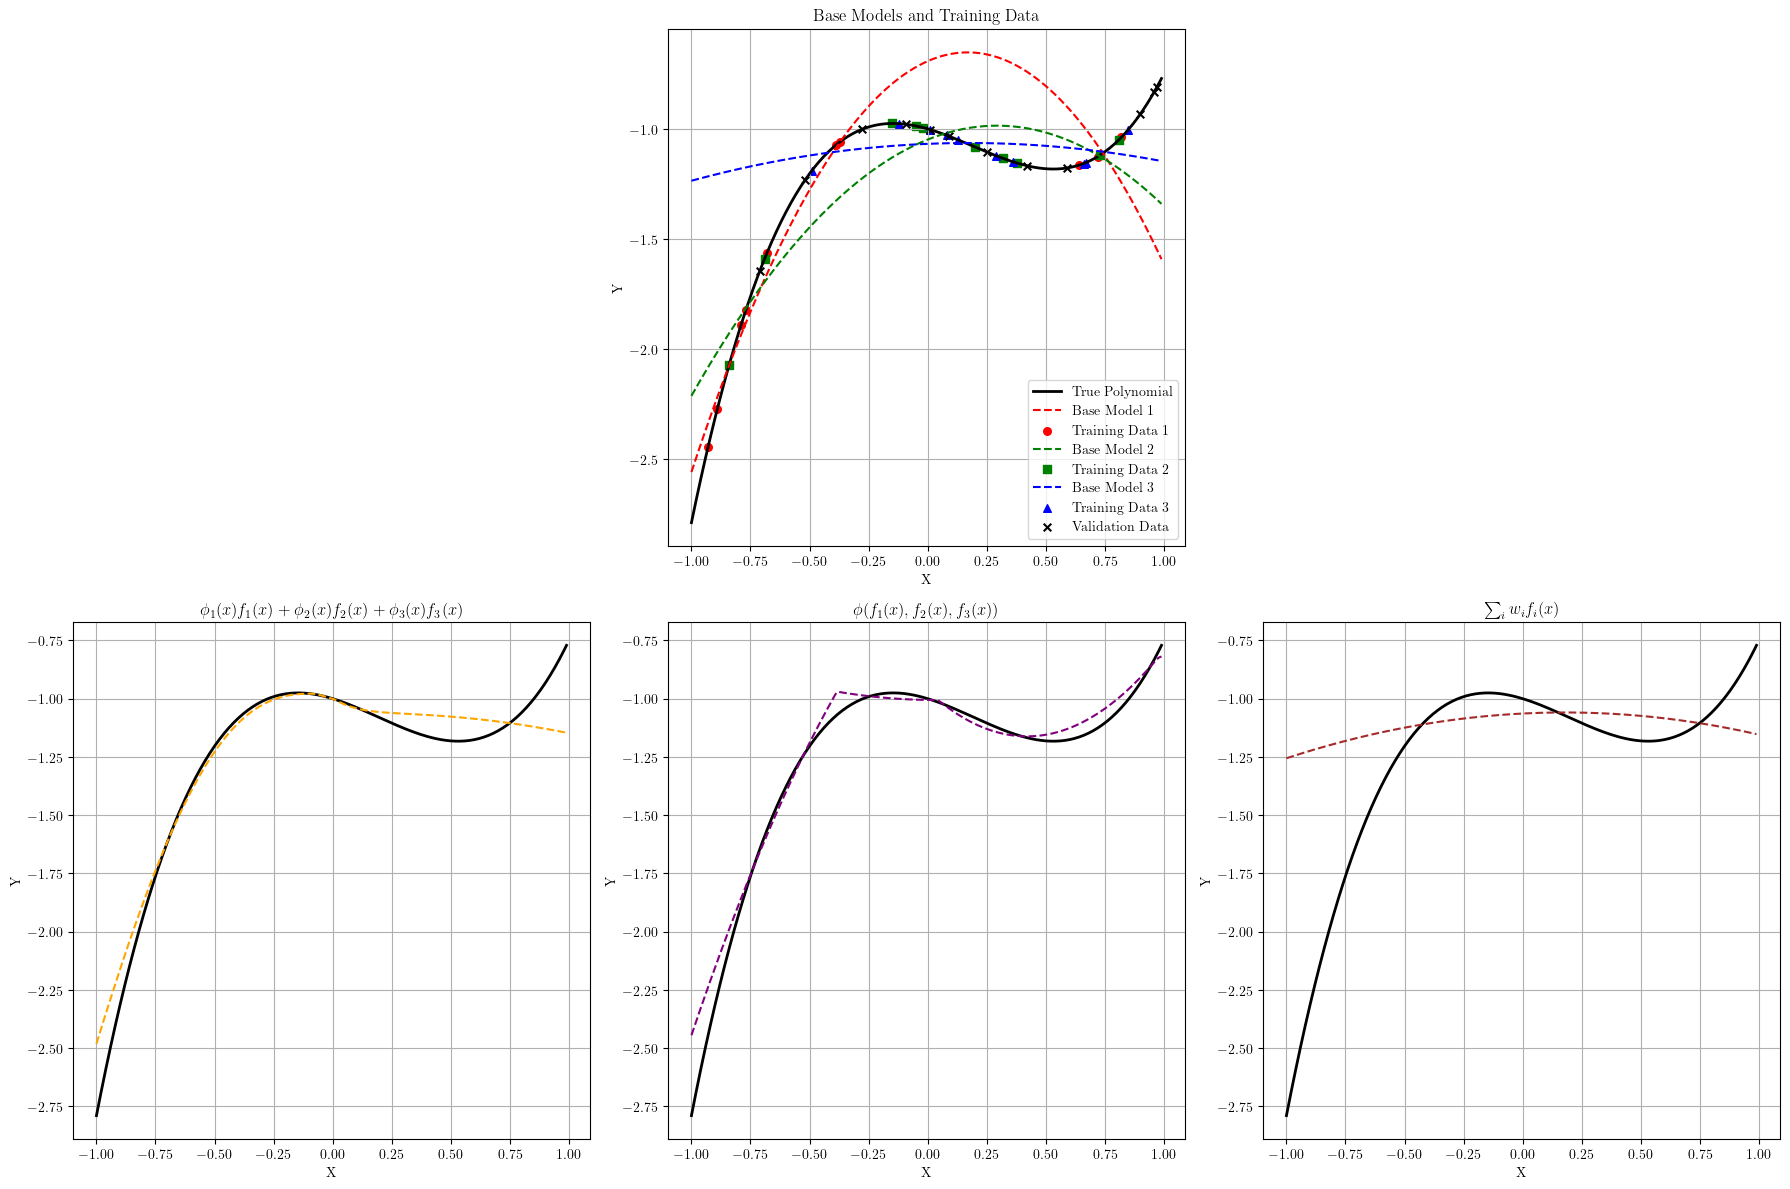

In [14]:
seed=12
np.random.seed(seed)
torch.manual_seed(10)
x = generate_points()
coefficients = [1.33, -0.77, -0.31, -1.00]
#coefficients = None
y, coefficients = generate_polynomial_values(x, degree=3, coefficients=coefficients)#, coefficients=[-1, 0, 4])
x_train, y_train = sample_train_set(x, y)
bootstrap_models, indices_list = create_bootstraps_with_indices(x_train, y_train, degree=2)
np.random.seed(24)
x_val, y_val = sample_val_set(x, y, 12)

# Get predictions of the base models on the test and validation sets
ensemble = BaseModelEnsemble(bootstrap_models)
f_val = ensemble.predict(x_val)
f_test = ensemble.predict(x)

# The true y values at the validation points (y_true_val) should be computed using the true polynomial function
y_true_val = np.polyval(coefficients, x_val)

# Train the weighted ensemble network using validation data
weighted_ensemble_net = train_weighted_ensemble_network(x_val, f_val, y_val)
# Predict on the test data using the trained weighted ensemble network
y_pred1 = predict_with_weighted_ensemble(weighted_ensemble_net, f_test, x)

# Train the direct ensemble network using validation data
direct_ensemble_net = train_direct_ensemble_network(f_val, y_val)
# Predict on the test data using the trained direct ensemble network
y_pred2 = predict_with_direct_ensemble(direct_ensemble_net, f_test)

# Train the fixed weight ensemble network using validation data
fixed_weight_ensemble_net = train_fixed_weight_ensemble(f_val, y_val)
# Predict on the test data using the trained fixed weight ensemble network
y_pred3, learned_weights = predict_with_fixed_weight_ensemble(fixed_weight_ensemble_net, f_test)


# Plotting the results
ensemble_predictions = [y_pred1, y_pred2, y_pred3]  # Replace y_pred2, y_pred3 with actual predictions if needed
labels = [
    r'$\phi_1(x) f_1(x) + \phi_2(x) f_2(x) + \phi_3(x) f_3(x)$',
    r'$\phi(f_1(x), f_2(x), f_3(x))$',
    r'$\sum_i w_i f_i(x)$'
]

# Plotting the results
plot_ensemble_results(x, y, [f_test[:, i] for i in range(3)], x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels)

In [15]:
def plot_ensemble_results_for_paper(x, y_true, base_models, x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels,
                                    linewidth=2,fontsize=12):
    """
    Plot the true polynomial, base models, training data, and ensemble predictions.
    Include markers to indicate which training points correspond to which base model.

    Parameters:
    - x (numpy.ndarray): The x values for the true polynomial and predictions.
    - y_true (numpy.ndarray): The y values of the true polynomial.
    - base_models (list): List of base model predictions.
    - x_train (numpy.ndarray): The x values for the training data.
    - y_train (numpy.ndarray): The y values for the training data.
    - indices_list (list): List of indices indicating which training points correspond to which base model.
    - x_val (numpy.ndarray): The x values for the validation data.
    - y_true_val (numpy.ndarray): True y values of the polynomial at validation points.
    - ensemble_predictions (list of numpy.ndarray): Predictions from the ensemble models.
    - labels (list of str): Labels for each ensemble prediction (e.g., ["y_pred1", "y_pred2", "y_pred3"]).
    """
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # First row: Plot only in the center figure
    # Hide the left and right plots in the first row
    #for ax in [axs[0, 0], axs[0, 2]]:
    #    ax.axis('off')

    # Center plot in the first row (True polynomial, base models, and training data)
    ax[0].plot(x, y_true, label='True Polynomial', color='black', linewidth=linewidth, zorder=-1)

    # Plot base models and training data
    colors = ['red', 'green', 'blue']
    markers = ['o', 's', '^']
    base_models_legends = ["$z_1(x)$", "$z_2(x)$", "$z_3(x)$"]

    for i, (f_model, (start_idx, end_idx)) in enumerate(zip(base_models, indices_list)):
        #ax_center.plot(x, f_model, label=f'Base Model {i+1}', color=colors[i], linestyle='--')
        ax[0].scatter(x_train[start_idx:end_idx], y_train[start_idx:end_idx], color=colors[i], label=f'Training Data {i+1}', s=20*linewidth, marker=markers[i],zorder=i+1)
    ax[0].tick_params(axis='both', labelsize=fontsize*0.8)
    ax[0].set_title('Training Data', fontsize=fontsize)
    ax[0].set_xlabel('$x$', fontsize=fontsize)
    ax[0].set_ylabel('$y$', fontsize=fontsize)
    ax[0].legend(fontsize=fontsize*0.8)
    ax[0].grid(True)

    ax[1].plot(x, y_true, label='True Polynomial', color='black', linewidth=linewidth,zorder=-1)
    ax[1].scatter(x_val, y_true_val, color='brown', label='Validation Data', s=20*linewidth, marker='o',zorder=3)

    for i, (f_model, (start_idx, end_idx)) in enumerate(zip(base_models, indices_list)):
        ax[1].plot(x, f_model, label=base_models_legends[i], color=colors[i], linestyle='--', linewidth=linewidth,zorder=i)

    # Plot the validation data (same for all models)
    ax[1].tick_params(axis='both', labelsize=fontsize*0.8)
    ax[1].set_title('Validation Data and Base Models', fontsize=fontsize)
    ax[1].set_xlabel('$x$', fontsize=fontsize)
    #ax[1].set_ylabel('$y$', fontsize=fontsize)
    ax[1].legend(fontsize=fontsize*0.8)
    ax[1].grid(True)

    colors = ['orange', 'purple', 'brown']
    ax[2].plot(x, y_true, linewidth=linewidth, color='black',label='True Polynomial')

    # Second row: Show ensemble predictions
    for i in range(3):
        ax[2].plot(x, ensemble_predictions[i], linestyle='--', color=colors[i],  label=labels[i], linewidth=linewidth)
    ax[2].tick_params(axis='both', labelsize=fontsize*0.8)
    ax[2].set_title("Ensembler's Output", fontsize=fontsize)
    ax[2].set_xlabel('$x$', fontsize=fontsize)
   #ax[2].set_ylabel('$y$', fontsize=fontsize)
    ax[2].legend(fontsize=fontsize*0.8)
    ax[2].grid(True)
    
    plt.tight_layout()
    #plt.show()


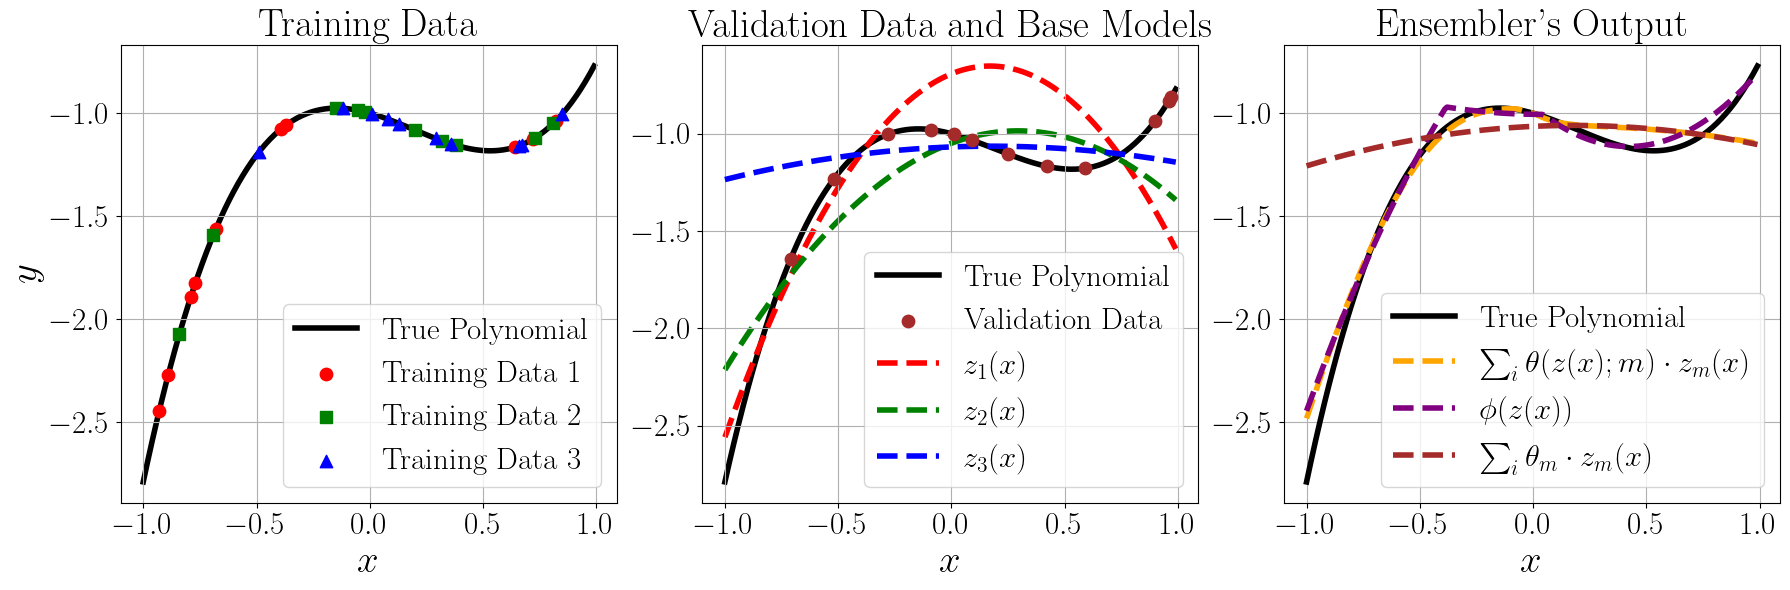

In [16]:
# Plotting the results
ensemble_predictions = [y_pred1, y_pred2, y_pred3]  # Replace y_pred2, y_pred3 with actual predictions if needed
labels = [
    r'$\sum_m \theta(z(x);m)\cdot z_m(x)$',
    r'$\phi(z(x))$',
    r'$\sum_m \theta_m \cdot z_m(x)$'
]
plot_ensemble_results_for_paper(x, y, [f_test[:, i] for i in range(3)], x_train, y_train, indices_list, x_val, y_true_val, ensemble_predictions, labels,
                                linewidth=4, fontsize=28)
plt.savefig("motivation_ensemble.pdf", bbox_inches='tight')

In [88]:
for i in range(3):
    print(np.mean((ensemble_predictions[i] - y) ** 2))

0.010068191803997368
0.005594100234256895
0.16609237962945142
